# Homework 2
---
Alice Xie, Hazel Kim, Lucas Salim, Seanne Chan

### Setting up the system, Loading in data through pandas and datatable, and Trimming the data

In [ ]:
conda install nbconvert==5.4.1

In [1]:
import pandas as pd
import numpy as np

In [2]:
#pip install datatable

In [3]:
import datatable as dt

In this assignment, to find genes that are sensitive to climate change and adaptation, we use some statistics methods including random forests, linear model, and correlation to select the important variants and related sub-variants.

The dataset has three parts: (1)the genetic mutation times of different genes of tree samples as our input; (2)the cloud density and (3)the minimum temperature of the environment of tree samples are our responses.

#### Reading data and producing a frame as the result

In [4]:
snp_orig = dt.fread("869_NoCal_CR0.99.tagSNPs_BigLD0.70.txt")

In [5]:
snp_orig.head(5)

,FID,IID,PAT,MAT,SEX,PHENOTYPE,Chr01_8003_G,Chr01_11528_T,Chr01_13272_G,Chr01_20328_A,…,Chr19_15924814_G,Chr19_15927152_C,Chr19_15931754_C,Chr19_15934532_G,Chr19_15937702_C
,▪▪▪▪,▪▪▪▪,▪,▪,▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪
0,BESC-418,BESC-418,0,0,0,−9,1,2,2,2,…,2,2,2,1,2
1,BESC-52,BESC-52,0,0,0,−9,2,1,2,2,…,2,2,2,2,2
2,BESC-79,BESC-79,0,0,0,−9,2,1,NA,2,…,2,2,2,2,1
3,BESC-246,BESC-246,0,0,0,−9,NA,NA,2,2,…,0,2,2,2,2
4,BESC-313,BESC-313,0,0,0,−9,2,1,2,1,…,2,2,2,2,2


In [6]:
snp_orig.shape

(869, 786075)

In [7]:
cloud_dens_orig = pd.read_csv("cloud_dens_yearAvg", sep="\t", header=None)
tmin_orig = pd.read_csv("tmin_yearAvg", sep="\t", header=None)

In [8]:
cloud_dens_orig = cloud_dens_orig.drop(0,axis=1)

In [9]:
cloud_dens_orig.shape

(869, 2)

In [10]:
tmin_orig = tmin_orig.drop(0,axis=1)

In [11]:
#Convert datable to pandas data frame
snp_orig_pd = snp_orig.to_pandas().astype('int64', errors='ignore')

In [12]:
snp_orig_pd.PAT.unique(), snp_orig_pd.MAT.unique(), snp_orig_pd.SEX.unique(), snp_orig_pd.PHENOTYPE.unique()

(array([0]), array([0]), array([0]), array([-9]))

In [13]:
snp_orig_pd = snp_orig_pd.drop(["IID","PAT","MAT","SEX","PHENOTYPE"], axis=1)

In [14]:
snp_orig_pd.head(5)

,FID,Chr01_8003_G,Chr01_11528_T,Chr01_13272_G,Chr01_20328_A,Chr01_21912_G,Chr01_21933_G,Chr01_28782_A,Chr01_29115_A,Chr01_34179_G,...,Chr19_15910732_A,Chr19_15918565_C,Chr19_15918732_T,Chr19_15919416_T,Chr19_15924615_G,Chr19_15924814_G,Chr19_15927152_C,Chr19_15931754_C,Chr19_15934532_G,Chr19_15937702_C
0,BESC-418,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2,2.0,...,2,2.0,2.0,2,2.0,2.0,2.0,2.0,1.0,2.0
1,BESC-52,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2,1.0,...,2,2.0,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0
2,BESC-79,2.0,1.0,NaN,2.0,2.0,1.0,1.0,2,2.0,...,2,2.0,2.0,1,1.0,2.0,2.0,2.0,2.0,1.0
3,BESC-246,NaN,NaN,2.0,2.0,2.0,1.0,2.0,1,2.0,...,2,2.0,NaN,2,2.0,0.0,2.0,2.0,2.0,2.0
4,BESC-313,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1,2.0,...,2,2.0,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0


### Setting cloud_dens_orig(cloud density) and tmin_orig(minimum temperature of a year) as organized data table

In [15]:
cloud_dens_orig = cloud_dens_orig.rename(columns = {1:"FID", 2:"DATA"}, errors = "raise")

In [16]:
tmin_orig = tmin_orig.rename(columns = {1:"FID", 2:"DATA"}, errors = "raise")

In [17]:
cloud_dens_orig.head(5)

,FID,DATA
0,BESC-418,0.693175
1,BESC-52,-0.025059
2,BESC-79,0.151925
3,BESC-246,-0.929824
4,BESC-313,-0.689698


In [18]:
tmin_orig.head(5)

,FID,DATA
0,BESC-418,0.377185
1,BESC-52,0.391660
2,BESC-79,0.490293
3,BESC-246,0.080623
4,BESC-313,0.467125


Now we loaded all of the data we need for finding genotypes associated with the minimum annual temperature and averagle cloud density. So we should start checking if the samples in snps, tmin, and cloud_dens in the same order(aligned appropriately).   

### Check Alignment of each row

In [19]:
tmin_orig["FID"].equals(cloud_dens_orig["FID"])

True

In [20]:
tmin_orig["FID"].equals(snp_orig_pd["FID"])

True

Since they are appropriately aligned, we can now explore the data. We should reduce the number of input variables, and get rid of samples with y = NA. It means, clearing the NA values in the responses datasets and align trim the genes dataset based on the length of the response datasets without NA values. 

### EDA before training data

First we will explore the two data sets `tmin_orig` and `cloud_dens_orig`. To do so, let's see if there is any relation between the two variables.

In [21]:
cloud_dens_orig.head(5)

,FID,DATA
0,BESC-418,0.693175
1,BESC-52,-0.025059
2,BESC-79,0.151925
3,BESC-246,-0.929824
4,BESC-313,-0.689698


In [22]:
tmin_orig.head(5)

,FID,DATA
0,BESC-418,0.377185
1,BESC-52,0.391660
2,BESC-79,0.490293
3,BESC-246,0.080623
4,BESC-313,0.467125


In [23]:
# merge the two dataframes together
merge = tmin_orig.merge(cloud_dens_orig, on = "FID", how = "left", suffixes=('tmin_x', 'cd_y'))
merge

,FID,DATAtmin_x,DATAcd_y
0,BESC-418,0.377185,0.693175
1,BESC-52,0.391660,-0.025059
2,BESC-79,0.490293,0.151925
3,BESC-246,0.080623,-0.929824
4,BESC-313,0.467125,-0.689698
...,...,...,...
864,SQMB-25-1,-0.431626,1.303344
865,SQMB-25-3,-0.431626,1.303344
866,SQMC-25-3,-0.742362,0.836930
867,VNDL-27-1,1.454448,1.929748


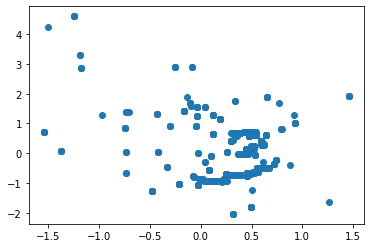

In [24]:
import matplotlib.pyplot as plt
plt.scatter(x = "DATAtmin_x", y = "DATAcd_y", data = merge)

/Users/alicexie4/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DATAtmin_x', ylabel='DATAcd_y'>

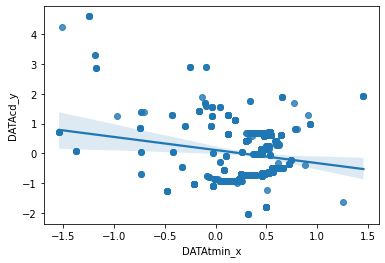

In [25]:
# draw line of best fit
import seaborn as sns
sns.regplot(merge['DATAtmin_x'], merge['DATAcd_y'])

In [26]:
col1, col2 = "DATAtmin_x", "DATAcd_y"
corr = merge[col1].corr(merge[col2])
print ("Correlation between ", col1, " and ", col2, "is: ", round(corr, 2))

Correlation between  DATAtmin_x  and  DATAcd_y is:  -0.18


Cleaning our data, we can check the relationship between cloud density and temperature which only has a slightly negative relationship (-0.18). Now, it's time to clean the data. We should reduce the number of input variables, and get rid of samples with y = NA.

### Data Cleaning

In [27]:
y_tm = tmin_orig["DATA"]
y_cd = cloud_dens_orig["DATA"]

At first, let's pick top 8000 features that have high variances! Because the genetic dataset includes more than 790000 features which are a lot, we decided to select 8000 features with high variance. It's because the change and progression of the data shows the progression of trees in adaptation. Through this variance thresholding, we don't have to worry about choosing features containing less information.

In [28]:
snp_orig_pd = snp_orig_pd.drop(["FID"], axis = 1)

In [29]:
feat_variances = snp_orig_pd.var()

In [30]:
feat8000 = feat_variances.nlargest(8000)

In [31]:
feat8000_pd = feat8000.to_frame()

In [32]:
feat8000_pd.index.name = 'Gene'
feat8000_pd.reset_index(inplace=True)

In [33]:
snp_orig_pd = snp_orig_pd.filter(items= feat8000_pd['Gene'])

Now we need to deal with NA values in the dataset. The best way is to eliminate samples with y = NA in cloud_dens and tmin data. 

In [34]:
X_tm = snp_orig_pd
X_cd = snp_orig_pd
X_tm = X_tm[~y_tm.isna()]
y_tm = y_tm[~y_tm.isna()]
X_cd = X_cd[~y_cd.isna()]
y_cd = y_cd[~y_cd.isna()]

In [35]:
X_tm.shape, y_tm.shape, X_cd.shape, y_cd.shape

((787, 8000), (787,), (869, 8000), (869,))

Looking at the size of each dataframe, we can confirm that rows having NA values are removed. We therefore can move on to the data splitting part, separating data as training, validation, and test part. 

#### Correlation between SNPs top 8000 features

We see that there is a very slight correlation between the two our responses. We will now utlize the SNPs data to build our model. But first let us see the correlation between each features that we selected.

In [36]:
corr_snp_orig_pd = snp_orig_pd.corr().abs()
corr_snp_orig_pd

,Chr17_14836028_A,Chr15_14720277_A,Chr12_13643610_A,Chr02_2327669_A,Chr10_8334810_C,Chr11_7204893_C,Chr14_9467337_A,Chr07_14496353_G,Chr12_4175050_C,Chr16_13977418_C,...,Chr07_878734_A,Chr02_12634614_G,Chr05_7496493_A,Chr17_8002387_T,Chr16_1606541_A,Chr01_11260613_A,Chr01_25874310_T,Chr18_1301831_T,Chr08_4072852_C,Chr05_23301261_T
Chr17_14836028_A,1.000000,0.036838,0.041114,0.028810,0.975679,0.631311,0.001578,0.011094,0.024452,0.005612,...,0.020961,0.001822,0.034894,0.036016,0.046702,0.050077,0.012121,0.016594,0.070679,0.012933
Chr15_14720277_A,0.036838,1.000000,0.076922,0.001407,0.022637,0.016182,0.059245,0.020466,0.025514,0.024337,...,0.026240,0.023675,0.003319,0.019517,0.027997,0.005342,0.036717,0.027456,0.034523,0.035398
Chr12_13643610_A,0.041114,0.076922,1.000000,0.019353,0.042747,0.008971,0.006492,0.016224,0.065568,0.038792,...,0.101832,0.065062,0.014755,0.008293,0.060549,0.016277,0.044787,0.017816,0.108487,0.010682
Chr02_2327669_A,0.028810,0.001407,0.019353,1.000000,0.038231,0.051569,0.048567,0.016844,0.036142,0.002240,...,0.031361,0.002197,0.032205,0.077649,0.080138,0.072462,0.087896,0.006952,0.051999,0.048288
Chr10_8334810_C,0.975679,0.022637,0.042747,0.038231,1.000000,0.615428,0.006946,0.014698,0.017650,0.005871,...,0.017284,0.014995,0.024463,0.027283,0.048660,0.057065,0.007228,0.026392,0.083725,0.002585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Chr01_11260613_A,0.050077,0.005342,0.016277,0.072462,0.057065,0.027942,0.008308,0.004199,0.000953,0.003732,...,0.022693,0.006219,0.047815,0.034073,0.083474,1.000000,0.002931,0.020081,0.126597,0.018260
Chr01_25874310_T,0.012121,0.036717,0.044787,0.087896,0.007228,0.081392,0.004112,0.064866,0.035377,0.057369,...,0.021616,0.073799,0.067001,0.067810,0.076746,0.002931,1.000000,0.033089,0.097872,0.002919
Chr18_1301831_T,0.016594,0.027456,0.017816,0.006952,0.026392,0.024222,0.024103,0.001361,0.065893,0.005058,...,0.044458,0.068648,0.043732,0.055068,0.009601,0.020081,0.033089,1.000000,0.002067,0.007889
Chr08_4072852_C,0.070679,0.034523,0.108487,0.051999,0.083725,0.105922,0.000730,0.094592,0.050267,0.006414,...,0.009785,0.081655,0.086674,0.112568,0.144642,0.126597,0.097872,0.002067,1.000000,0.011177


In [37]:
def pd_fill_diagonal(df, value):
    idces = df.index.intersection(df.columns)
    stacked = df.stack(dropna=False)
    stacked.update(pd.Series(value,
                             index=pd.MultiIndex.from_arrays([idces,
                                                              idces])))
    df.loc[:, :] = stacked.unstack()

c_zero = corr_snp_orig_pd
pd_fill_diagonal(c_zero, 0)

In [38]:
s = c_zero.unstack()
s.head(5)
so = s.sort_values(kind="quicksort")

In [39]:
so_key = so[63999800:64000000].to_frame()
so_key #it gives the top 200 correlated features with correlation > 0.85

,,0
Chr06_19352550_A,Chr06_19352042_G,0.850853
Chr06_19352042_G,Chr06_19352550_A,0.850853
Chr01_4319359_G,Chr01_4319715_A,0.851839
Chr01_4319715_A,Chr01_4319359_G,0.851839
Chr01_26323804_A,Chr01_26307470_A,0.852797
...,...,...
Chr02_14885760_C,Chr02_14885759_G,1.000000
Chr07_13130466_T,Chr07_13130465_T,1.000000
Chr18_5615512_T,Chr18_5615515_T,1.000000
Chr18_5615515_T,Chr18_5615512_T,1.000000


### Data Splitting

In [30]:
# pip install scikit-learn

In [31]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics import r2_score, mean_squared_error

Let's hold out 20% of the data for testing, and around 15% of the data for validation

In [32]:
X_tm_train, X_tm_test, y_tm_train, y_tm_test = train_test_split(X_tm, y_tm, test_size=0.2, random_state=1234)
X_tm_train, X_tm_valid, y_tm_train, y_tm_valid = train_test_split(X_tm_train, y_tm_train, test_size=0.2, random_state=331)

In [33]:
X_tm_train.shape, X_tm_valid.shape, X_tm_train.shape

((503, 8000), (126, 8000), (503, 8000))

In [34]:
X_cd_train, X_cd_test, y_cd_train, y_cd_test = train_test_split(X_cd, y_cd, test_size=0.2, random_state=1234)
X_cd_train, X_cd_valid, y_cd_train, y_cd_valid = train_test_split(X_cd_train, y_cd_train, test_size=0.2, random_state=331)

From now on, we are going to compute the validation error of a model by filling the NaN with knn methods. To train an untuned random forest model and Lasso, let's begin by testing out these imputation methods.

In [35]:
imputers = {
    "knn_imputer": KNNImputer(),
    # "iterative_imputer": IterativeImputer(max_iter=10, random_state=0)
}
models = {
    "rf": RandomForestRegressor(n_estimators=100, min_samples_leaf=5),
    "lasso": Lasso()
}

pipes = {}
for imputer_name, imputer in imputers.items():
    for model_name, model in models.items():
        pipe = Pipeline(steps=[(imputer_name, imputer), (model_name, model)])
        pipe_name = imputer_name + "+" + model_name
        pipes[pipe_name] = pipe
pipes

{'knn_imputer+rf': Pipeline(steps=[('knn_imputer', KNNImputer()),
                 ('rf', RandomForestRegressor(min_samples_leaf=5))]),
 'knn_imputer+lasso': Pipeline(steps=[('knn_imputer', KNNImputer()), ('lasso', Lasso())])}

As simply ommitting missing values can cause a non-trivial problem by reducing the degrees of freedom, we should replace missing values with other values. Using kNN algorithm is in this sense useful to estimate the value. With the help of completed values of neighboring observations, it imputes the missing value based on the feature and data similarity. Since it predicts the missing value in reference to the mean of the neighbors, it has higher accuracy than picking mere median or mean of the sample.

 For the NaN values in the genes data set, our X, we decide to use KNN (k-nearest neighbor) = 5 to fill in the NaN in our later computation of train, valid, and test sets. KNN gives a more logical solution than filling in the median values of the feature because it provides an environment and connection of trees sharing the similar features and yields a more accurate answer. Setting KNN=5, we avoids the non-integer created by even numbers(=4,6) and over sampling and connecting(=7,10).


In [36]:
valid_errs_tm = {}
for pipe_name, pipe in pipes.items():
    print(pipe_name)
    pipe.fit(X_tm_train, y_tm_train)
    valid_errs_tm[pipe_name] = pipe.score(X_tm_valid, y_tm_valid)
valid_errs_tm

knn_imputer+rf
knn_imputer+lasso


{'knn_imputer+rf': 0.15552725728709305,
 'knn_imputer+lasso': -0.011164561784757776}

In [37]:
valid_errs_cd = {}
for pipe_name, pipe in pipes.items():
    print(pipe_name)
    pipe.fit(X_cd_train, y_cd_train)
    valid_errs_cd[pipe_name] = pipe.score(X_cd_valid, y_cd_valid)
valid_errs_cd

knn_imputer+rf
knn_imputer+lasso


{'knn_imputer+rf': 0.36919931130989125,
 'knn_imputer+lasso': -5.466587662650291e-05}

Using cross validation and parameters, we can tune out random forest model and compare the validation errors of the tuned random forest and lasso. Let's add CV to tune hyperparameters on tm data!

---
From now on, data is focused on tm data. We'll deal with cd data after finishing the heatmaps of chromes based on tm data.

In [38]:
cv_param_grid_all = {
    "rf__min_samples_leaf": [1, 3, 5, 10],
    "lasso__alpha": np.logspace(-2, 2, 10),
    # can also tune parameters in the imputation step
    "knn_imputer__n_neighbors": [5]
}

In [39]:
valid_errs_tm = {}
for pipe_name, pipe in pipes.items():
    print(pipe_name)
    # get relevant CV parameters given the steps of the pipeline
    cv_param_grid_tm = {key: cv_param_grid_all[key] for key in cv_param_grid_all.keys() if key.startswith(tuple(pipe.named_steps.keys()))}
    # run CV for pipeline
    pipe_search_tm = GridSearchCV(pipe, cv_param_grid_tm)
    pipe_search_tm.fit(X_tm_train, y_tm_train)
    valid_errs_tm[pipe_name] = pipe_search_tm.score(X_tm_valid, y_tm_valid)
valid_errs_tm

knn_imputer+rf
knn_imputer+lasso


{'knn_imputer+rf': 0.19695086949565788,
 'knn_imputer+lasso': 0.24232301735190465}

With piping, we could conduct model training for minimum temperature. Now, check the best model for minimum temperature. It seems that using lasso based on the knn_imputer gives higher validation score than tuned random forests for y=min temperature(y_min)! Lasso chooses a representitive among the correlated neighboring variables in a high dimension space. So we'll stick to the lasso model with knn_imputer. To begin with, we need to figure out the best parameters for knn imputer here.

In [40]:
pipe_search_tm.best_params_

{'knn_imputer__n_neighbors': 5, 'lasso__alpha': 0.01}

Overall, the Lasso with alpha = 0.01 yields the highest accuracy for both cloud and temperature. So, let's start building our model based on KNN=5 + Lasso, alpha = 0.01.

In [41]:
best_pipe_tm = pipe_search_tm.best_estimator_

In [42]:
best_pipe_tm.predict(X_tm_test)
# pretty close to y_tm_test

array([ 0.02578133,  0.22429615,  0.38438101,  0.52734341,  0.25041818,
        0.0896334 ,  0.35204284,  0.61976329,  0.69024773, -0.18527972,
        0.27874016, -0.03258995,  0.63291849,  0.50641507,  0.56712569,
        0.3630744 ,  0.33587236,  0.21299257,  0.22680164,  0.17164701,
        0.37143804, -0.22874939,  0.03884081,  0.33927849,  0.19109489,
        0.19315779,  0.34678442,  0.40505863,  0.15421988,  0.07290453,
        0.34233809,  0.18053397,  0.16534672,  0.44915073,  0.29455976,
        0.14843595,  0.38701125,  0.13681015,  0.38562325,  0.4487767 ,
       -0.30820642,  0.42384488,  0.19384855,  0.17527605,  0.03349766,
        0.46172263,  0.49233731,  0.36594258,  0.40253306,  0.5909698 ,
        0.41530323,  0.49031025,  0.25361151,  0.35157262,  0.24873735,
        0.36646409,  0.43086958,  0.4050188 ,  0.42097643,  0.33169719,
        0.26733262,  0.3796209 ,  0.55854287,  0.37971084,  0.47101098,
        0.02744459,  0.33441755,  0.49988043,  0.21518701,  0.27

In [43]:
imputerknn = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputerknn.fit(X_tm_train)
Xtrans = imputerknn.transform(X_tm_train)

In [44]:
X_tm_train_knn = pd.DataFrame(Xtrans, columns = [X_tm_train.columns])

In [45]:
X_tm_train_knn.isnull().values.any()

False

In [46]:
X_tm_train_knn.head(5)

,Chr17_14836028_A,Chr15_14720277_A,Chr12_13643610_A,Chr02_2327669_A,Chr10_8334810_C,Chr11_7204893_C,Chr14_9467337_A,Chr07_14496353_G,Chr12_4175050_C,Chr16_13977418_C,...,Chr07_878734_A,Chr02_12634614_G,Chr05_7496493_A,Chr17_8002387_T,Chr16_1606541_A,Chr01_11260613_A,Chr01_25874310_T,Chr18_1301831_T,Chr08_4072852_C,Chr05_23301261_T
0,0.0,2.0,0.0,2.0,0.0,2.0,2.0,0.0,2.0,0.0,...,2.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0
1,2.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,...,2.0,1.0,0.0,2.0,1.0,1.0,1.0,2.0,0.0,2.0
2,2.0,2.0,1.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,...,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0
3,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,...,2.0,1.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,1.0
4,0.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,0.0,2.0,...,2.0,1.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,2.0


We successfully replaced null values with the values of 5 nearest neighbors! Now it's time to fit the prediction model with new dataframe we created. As stated above, our prediction model is Lasso. Lasso has the advantage of having high interpretability by ripping out correlated variable(sparsity).

In [47]:
modellasso = Lasso(alpha=0.01)

In [48]:
modellasso.fit(X_tm_train_knn, y_tm_train)

C:\Users\naodr\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


Lasso(alpha=0.01)

In [49]:
yhat = modellasso.predict(X_tm_train_knn)
yhat

C:\Users\naodr\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


array([ 3.66688088e-01,  4.94013181e-01,  8.23903646e-02,  3.40952189e-01,
        3.65935211e-01, -1.55711308e-01,  4.20755895e-01,  4.17268962e-01,
        2.03012064e-01,  5.57974728e-01,  3.66870382e-01,  3.20951598e-01,
        4.82159890e-01,  4.89182216e-01,  2.68370585e-02,  4.15976501e-01,
        5.72608086e-01,  4.28199845e-01,  2.65013632e-01,  4.07542270e-01,
        4.35002801e-01,  4.12484657e-01,  3.88492083e-01,  7.82590132e-03,
        4.74001440e-01,  1.15499953e-01, -6.95483702e-02,  2.74084624e-01,
        5.68044095e-01,  4.27314928e-01,  5.44399834e-01, -6.37231302e-02,
        4.70892274e-01,  4.58659754e-01, -1.16609422e-01,  1.77518551e-01,
        4.62213616e-01,  4.37019383e-01,  1.98356990e-01,  5.46578716e-01,
        3.79967990e-01,  5.06059247e-01,  4.77397560e-01,  4.69429789e-01,
        1.69743213e-01,  5.33385319e-01,  5.35067423e-01,  2.89549979e-01,
        9.54942706e-02, -4.95126341e-01,  4.32373432e-01,  5.08238414e-01,
        4.31303876e-01, -

These are the predicted values of Lasso with training dataset of minimum temperature of a year. 

### Developing a predictive model on tm data - LASSO

Now let's fit the model again with test data, and check its validity with the model score. We checked it with pipe_search a few cells above, but we'll re-do it with exact variable named X_tm_test_knn.

In [50]:
imputerknn = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputerknn.fit(X_tm_test)
Xtranstest = imputerknn.transform(X_tm_test)
X_tm_test_knn = pd.DataFrame(Xtranstest, columns = [X_tm_test.columns])

In [51]:
#fit model
modellasso.fit(X_tm_train_knn, y_tm_train)
feature_names = list(X_tm_train_knn)
y_pred = modellasso.predict(X_tm_test_knn)
y_pred

C:\Users\naodr\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\naodr\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


array([ 0.02578133,  0.22429615,  0.38438101,  0.52549226,  0.25123768,
        0.0896334 ,  0.35204284,  0.61976329,  0.68854647, -0.18691271,
        0.27874016, -0.03258995,  0.63507543,  0.50641507,  0.5674675 ,
        0.36320941,  0.33587236,  0.21523595,  0.23346693,  0.17006107,
        0.37143804, -0.22769284,  0.05094393,  0.34086444,  0.19109489,
        0.19309011,  0.3454704 ,  0.4139305 ,  0.18223426,  0.07286003,
        0.340973  ,  0.18053397,  0.16341732,  0.44915073,  0.31299406,
        0.14741658,  0.38576517,  0.13608167,  0.38973509,  0.45046851,
       -0.30820642,  0.4212034 ,  0.21823803,  0.17527605,  0.03349766,
        0.46172263,  0.49233731,  0.36594258,  0.40253306,  0.5909698 ,
        0.40649014,  0.48938467,  0.25361151,  0.35157262,  0.24873735,
        0.36646409,  0.43086958,  0.4050188 ,  0.42570948,  0.31635284,
        0.2686008 ,  0.3796209 ,  0.56290189,  0.37971084,  0.46146909,
        0.03548612,  0.3552236 ,  0.49389698,  0.21570744,  0.27

In [52]:
#create the model score
modellasso.score(X_tm_test_knn, y_tm_test), modellasso.score(X_tm_train_knn, y_tm_train)

C:\Users\naodr\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\naodr\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


(0.2958496110653016, 0.9061824465362117)

As the lasso model is fitted based on the tmin test dataset, we can move on to the next point; getting the coefficient of lasso.

In [53]:
#Getting the coefficient of lasso
arr = modellasso.coef_
arr

array([-0.        , -0.01235645,  0.00935519, ...,  0.        ,
       -0.        , -0.        ])

As *arr* has only a numerical value of coefficient, we should combine coefficients of features with their respective feature names. Then, sort list by magnitude, and print top 10:

In [54]:
variants = list(zip(arr, feature_names))
variants = sorted(variants, key=lambda pair: np.abs(pair[0]), reverse=True)
for i in range(10):
    print(variants[i])

(-0.039583150368495246, ('Chr11_17466980_T',))
(0.03913086993310521, ('Chr06_17820635_T',))
(0.03509624153893438, ('Chr01_13773756_G',))
(0.031022542489512, ('Chr09_752989_T',))
(0.030687944431029873, ('Chr06_9260168_T',))
(-0.027930123075287153, ('Chr02_11473957_C',))
(-0.02586094481955307, ('Chr05_12792631_C',))
(-0.024726381784734436, ('Chr06_13395022_C',))
(0.02423659811952697, ('Chr10_17987523_C',))
(-0.024168945139507996, ('Chr17_11646919_G',))


Refit Knn to orignial data set so that we can compute correlation matrix.

In [55]:
imputerknn = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputerknn.fit(X_tm)
Xtranstest = imputerknn.transform(X_tm)
X_tm_knn = pd.DataFrame(Xtranstest, columns = X_tm.columns)

In [104]:
X_tm_knn

,Chr03_597_G,Chr15_672_C,Chr16_77832_A,Chr17_84537_T,Chr12_97580_T,Chr05_104015_C,Chr12_115142_A,Chr16_116520_A,Chr16_116610_C,Chr01_117467_G,...,Chr01_50146733_T,Chr01_50156650_C,Chr01_50190333_T,Chr01_50236149_G,Chr01_50250552_G,Chr01_50321691_C,Chr01_50363739_C,Chr01_50377105_C,Chr01_50448931_T,Chr01_50474015_A
0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,0.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0
1,2.0,0.0,0.0,2.0,1.0,2.0,0.4,0.0,2.0,2.0,...,2.0,1.0,0.0,1.2,2.0,1.0,0.0,0.0,0.0,0.8
2,1.0,0.6,0.8,1.4,1.0,1.0,0.0,1.0,2.0,2.0,...,2.0,1.2,2.0,0.0,0.0,1.4,0.0,0.0,2.0,0.0
3,0.0,2.0,0.8,0.0,2.0,0.0,1.0,0.0,2.0,1.0,...,2.0,0.0,1.0,0.6,0.0,2.0,0.0,0.0,2.0,0.0
4,0.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,...,2.0,0.0,2.0,0.0,2.0,1.0,1.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,...,2.0,0.0,2.0,1.0,2.0,0.0,2.0,2.0,2.0,1.0
783,1.0,2.0,0.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,...,2.0,0.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
784,1.0,1.0,0.0,1.0,1.0,2.0,2.0,0.0,2.0,1.0,...,0.0,2.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0,1.0
785,0.0,1.0,2.0,1.0,2.0,0.0,2.0,0.0,1.0,2.0,...,1.0,1.0,2.0,2.0,1.0,1.0,0.0,1.0,2.0,1.0


In [57]:
import seaborn 

Sort columns by feature position in chromossome

In [58]:
def getPosition(featureName):
    return int(featureName.split("_")[1])

X_tm_knn = X_tm_knn.reindex(sorted(X_tm_knn.columns, key = getPosition), axis=1) 

In [59]:
for i in range(10):
    print(variants[i])

(-0.039583150368495246, ('Chr11_17466980_T',))
(0.03913086993310521, ('Chr06_17820635_T',))
(0.03509624153893438, ('Chr01_13773756_G',))
(0.031022542489512, ('Chr09_752989_T',))
(0.030687944431029873, ('Chr06_9260168_T',))
(-0.027930123075287153, ('Chr02_11473957_C',))
(-0.02586094481955307, ('Chr05_12792631_C',))
(-0.024726381784734436, ('Chr06_13395022_C',))
(0.02423659811952697, ('Chr10_17987523_C',))
(-0.024168945139507996, ('Chr17_11646919_G',))


In our linear model, we selected the top 10 features with highest coefficients to indicate their influence and prevalence in the trees’ adaptation under the responses of cloud density and temperature. We take them as our important variants.

Finding their subvariant groups, we choose to refit our whole dataset into KNN and grab the neighboring features to check their correlation for our subvariant groups.


### EDA - checking the magnitude of correlation (minimum temperature)

Now we are going to create a function that generates the correlation matrix between features of same chromossome number.   
Takes as input FEATURENAME (the name of the signal feature - one of the important features we got from LASSO) and also SOMERANGE - a specic range for the number of close features to consider. We also center the signal feature so that in the heat map the signal feature is the one in the middle. 

In [60]:
def generateHeatMap(featureName, someRange):
    thisChromosome = X_tm_knn.filter(regex=str('^' + featureName[0:5]), axis=1)
    ind = list(thisChromosome.columns).index(featureName)
    neighborhood = thisChromosome.iloc[:, ind-someRange:ind+someRange+1]
    seaborn.heatmap(neighborhood.corr())

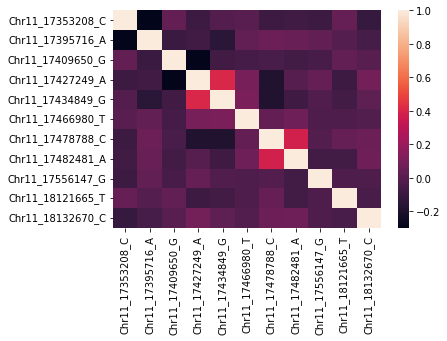

In [61]:
generateHeatMap('Chr11_17466980_T', 5)

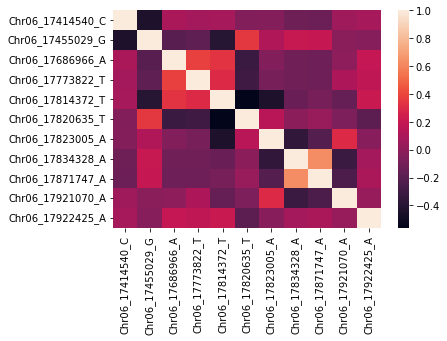

In [62]:
generateHeatMap('Chr06_17820635_T', 5)

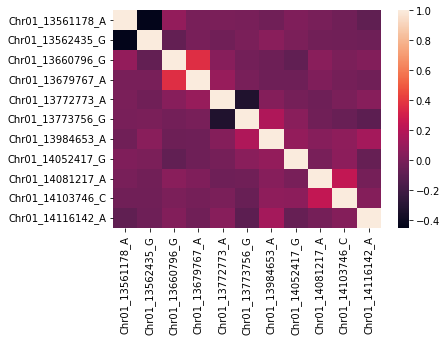

In [63]:
generateHeatMap('Chr01_13773756_G', 5)

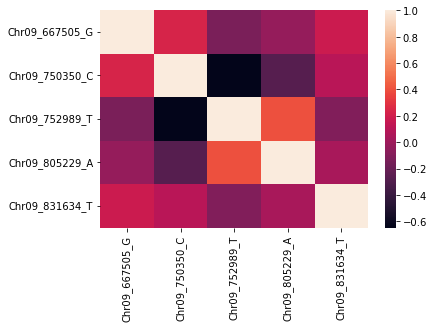

In [64]:
generateHeatMap('Chr09_752989_T'  , 2) # Important subgroup of three features

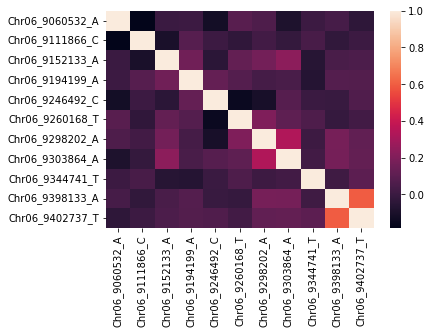

In [65]:
generateHeatMap('Chr06_9260168_T' , 5)

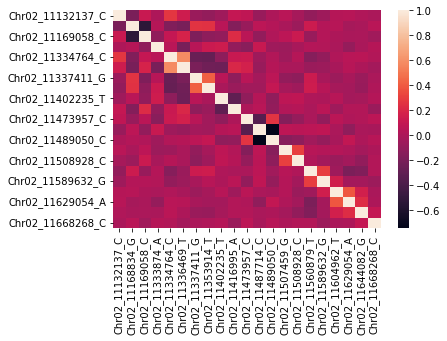

In [66]:
generateHeatMap('Chr02_11473957_C', 10) # Important subgroup of three features:

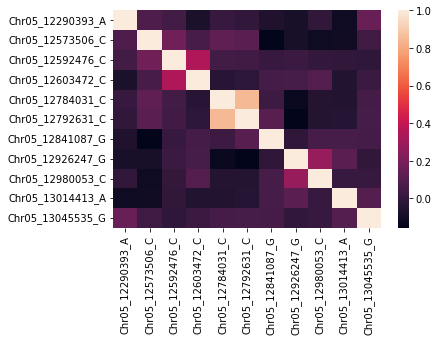

In [67]:
generateHeatMap('Chr05_12792631_C', 5) # Special attention to this one (strong correlation with Chr05_12784031_C)

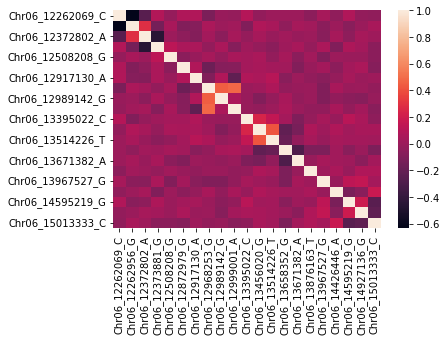

In [68]:
generateHeatMap('Chr06_13395022_C', 10)

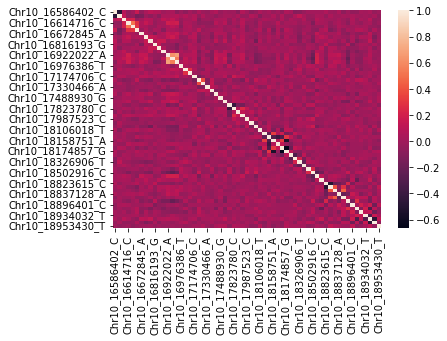

In [69]:
generateHeatMap('Chr10_17987523_C', 30)

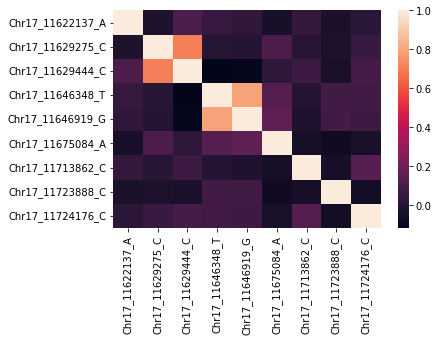

In [70]:
generateHeatMap('Chr17_11646919_G', 4) # Special attention to this one (strong correlation with Chr17_11646348_T)
# As we will see, Chr17_11646348_T also appear as one of top 100 (most important) features.

Then, generate Correlation HeatMap among top (most important) k features:

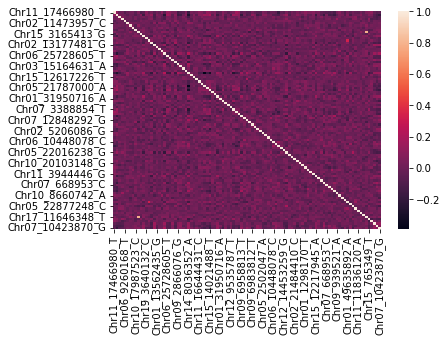

In [71]:
def top(k):
    important = map(lambda pair: pair[1][0], variants[0:k+1])
    seaborn.heatmap(X_tm_knn[important].corr())
top(100) #Look at top 100 features

Notice two Chr17 features are higly correlated:

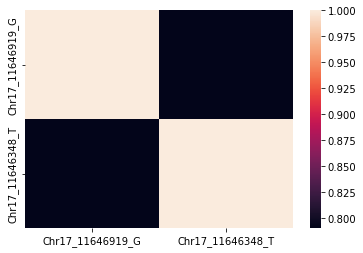

In [72]:
def top(k):
    important = map(lambda pair: pair[1][0], variants[0:k+1])
    seaborn.heatmap(X_tm_knn[important].filter(regex="^Chr17").corr()) # Get only Chromosome17
top(100)

They are: Chr17_11646919_G and Chr17_11646348_T

In [73]:
11646919 - 11646348 # Check how close they are (pretty close)

571

In [74]:
pair = list(filter(lambda pair: pair[1][0] == "Chr17_11646919_G" or pair[1][0] == "Chr17_11646348_T", variants))
print(pair)

[(-0.024168945139507996, ('Chr17_11646919_G',)), (-0.009962934253989109, ('Chr17_11646348_T',))]


Through this heatmap, we can conclude Chr17_11646919_G and Chr17_11646348_T are highly correlated!

After obtaining our top features, we used heatmap to exhibit potential subvariants group neighboring our key variants. For minimum temperature, we have 'Chr05_12792631_C(key variant)' and ‘Chr05_12784031_C’; Around our key variant ‘Chr10_17987523_C‘, there is a cluster subvariant group centered at ‘Chr10_16922022_A’; key variant 'Chr17_11646919_G' has a pair variant with correlation higher than 0.8, which is ‘Chr17_11646348_T’.

### Fitting models for Cloud Density

---
Now, let's deal with cd data. It basically goes over the same process as we did with tm data. The first step is to check the model for cloud density using knn imputation.

In [75]:
valid_errs_cd = {}
for pipe_name, pipe in pipes.items():
    print(pipe_name)
    cv_param_grid_cd = {key: cv_param_grid_all[key] for key in cv_param_grid_all.keys() if key.startswith(tuple(pipe.named_steps.keys()))}
    # run CV for pipeline
    pipe_search_cd = GridSearchCV(pipe, cv_param_grid_cd)
    pipe_search_cd.fit(X_cd_train, y_cd_train)
    valid_errs_cd[pipe_name] = pipe_search_cd.score(X_cd_valid, y_cd_valid)
valid_errs_cd

knn_imputer+rf
knn_imputer+lasso


{'knn_imputer+rf': 0.362927690657153, 'knn_imputer+lasso': 0.5849652269443779}

In [76]:
pipe_search_cd.best_params_

{'knn_imputer__n_neighbors': 5, 'lasso__alpha': 0.01}

In [77]:
best_pipe_cd = pipe_search_cd.best_estimator_

array([ 0.17018769,  1.11753923, -0.04982468,  0.31631226,  0.09515646,
       -0.78608878, -0.70856697, -0.04084623, -0.3397309 , -0.21437109,
       -0.10537486,  0.33208621, -0.00443549,  0.21058088, -0.01317806,
        0.56188626, -1.28508733, -0.83001127,  0.71146923,  1.25623998,
        0.15592942,  0.21675509,  0.78713921,  0.88541148,  0.61682131,
       -0.23802706, -0.52891557, -0.20754551, -0.4223447 , -0.50135997,
        0.75308296, -0.10389626, -0.72024566,  1.22530942, -1.78399194,
        1.50781131,  0.63700411, -0.3525997 ,  0.31673392, -0.77013902,
       -0.15388994,  0.96791446,  0.70841974,  0.68899867,  0.71307351,
        0.53438436,  0.36172184, -0.24180505, -1.13224734,  0.46115434,
        0.18734778,  0.062358  ,  0.52933237,  0.17485681, -0.05204118,
        0.59353302, -0.43532826,  0.09500901,  0.50844729,  0.07736983,
       -0.18789153,  0.40521232,  0.16885524,  1.0392304 ,  0.06934985,
        0.06526849, -0.26443399,  0.82379309, -0.16409881, -0.64

In [78]:
imputerknn1 = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputerknn1.fit(X_cd_train)
Xtrans_cd = imputerknn1.transform(X_cd_train)

In [79]:
X_cd_train_knn = pd.DataFrame(Xtrans_cd, columns = [X_cd_train.columns])
X_cd_train_knn.isnull().values.any()

False

In [80]:
X_cd_train_knn.head()

,Chr17_14836028_A,Chr15_14720277_A,Chr12_13643610_A,Chr02_2327669_A,Chr10_8334810_C,Chr11_7204893_C,Chr14_9467337_A,Chr07_14496353_G,Chr12_4175050_C,Chr16_13977418_C,...,Chr07_878734_A,Chr02_12634614_G,Chr05_7496493_A,Chr17_8002387_T,Chr16_1606541_A,Chr01_11260613_A,Chr01_25874310_T,Chr18_1301831_T,Chr08_4072852_C,Chr05_23301261_T
0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,2.0,2.0,1.0,...,1.0,2.0,1.0,0.0,2.0,2.0,2.0,0.0,0.0,1.0
1,2.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.6,...,0.0,2.0,0.0,1.0,2.0,2.0,2.0,0.0,2.0,0.0
2,2.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,1.0,0.0,2.0,1.0,2.0,0.0,2.0,2.0
3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,...,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0
4,2.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,...,2.0,2.0,0.0,1.0,2.0,0.0,2.0,1.0,1.0,0.0


Like tm dataset, we successfully replaced null values with the values of 5 nearest neighbors. Again, we'll fit the prediction model with new dataframe we created. As we did with tm dataset, our prediction model is Lasso.

In [81]:
modellasso1 = Lasso(alpha=0.01)
modellasso1.fit(X_cd_train_knn, y_cd_train)

C:\Users\naodr\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


Lasso(alpha=0.01)

In [82]:
yhat1 = modellasso1.predict(X_cd_train_knn)
yhat1

C:\Users\naodr\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


array([ 1.35088671e+00, -3.27870056e-01,  2.05838837e-01, -1.28283900e-03,
       -7.48855259e-01, -4.34585446e-01, -5.53276754e-01, -5.28620695e-01,
       -1.21628539e-01,  1.31465949e+00,  7.10581929e-01,  1.01469729e+00,
        5.14635858e-01, -7.30817714e-01,  6.69345562e-01,  1.83054363e+00,
        2.89376762e-01, -7.46523862e-01,  3.84891531e-01,  4.48663045e-01,
       -8.55240087e-01, -4.97707436e-01, -9.03463267e-01,  7.10408625e-01,
        3.67396223e-03,  5.36759535e-01,  6.68268363e-01,  1.83516065e-01,
        1.28683434e-02,  5.05163773e-01,  1.14065042e-01,  1.47502395e+00,
       -9.72691817e-01,  4.68768244e-01,  1.11829610e+00, -1.77018534e+00,
       -1.06758032e-01, -5.16358532e-01, -1.16238184e-01, -4.76841435e-01,
       -5.04414758e-01, -1.68584009e+00,  4.83493478e-01,  3.28512533e+00,
        6.96364629e-01,  1.56903993e-01, -9.19402804e-01, -9.21374913e-01,
       -8.55319026e-01,  1.29283724e+00,  4.36308683e-01,  6.30713693e-01,
        2.53394250e+00,  

These are the predicted values of Lasso with training dataset of cloud density.

#### Fitting the test data on our model (kNN + LASSO)

Now let's fit the model again with test data, and check its validity with the model score. Our purpose is to utilize X_cd_test_knn to fit a Lasso model.

In [83]:
imputerknn1 = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputerknn1.fit(X_cd_test)
Xtranstest1 = imputerknn1.transform(X_cd_test)
X_cd_test_knn = pd.DataFrame(Xtranstest1, columns = [X_cd_test.columns])

In [84]:
imputerknn11 = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputerknn11.fit(X_cd_test)
Xtranstest11 = imputerknn11.transform(X_cd_test)
X_cd_test_knn = pd.DataFrame(Xtranstest11, columns = X_cd_test.columns)

In [85]:
#fit model (with test data)
modellasso1.fit(X_cd_train_knn, y_cd_train)
feature_names1 = list(X_cd_train_knn)
y_pred1 = modellasso1.predict(X_cd_test_knn)
y_pred1

C:\Users\naodr\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\naodr\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


array([ 0.18386553,  1.12885919, -0.05963254,  0.31656693,  0.1068896 ,
       -0.80675884, -0.71021578, -0.05602887, -0.34136876, -0.20008889,
       -0.10895748,  0.35028238, -0.02143664,  0.25580849, -0.01317806,
        0.56828459, -1.27775337, -0.82565498,  0.63618921,  1.25623998,
        0.15592942,  0.21675509,  0.78388541,  0.8402388 ,  0.61682131,
       -0.23104287, -0.5235974 , -0.20754551, -0.4223447 , -0.48782376,
        0.77868148, -0.10389626, -0.7826079 ,  1.22203487, -1.78377437,
        1.50781131,  0.63700411, -0.35411639,  0.3017672 , -0.77013902,
       -0.15388994,  1.01684029,  0.70841974,  0.6905977 ,  0.67784381,
        0.51478957,  0.35429495, -0.24180505, -1.1430007 ,  0.44674828,
        0.18830655,  0.062358  ,  0.50222196,  0.17485681, -0.03751587,
        0.60369524, -0.43970148,  0.09652222,  0.52353824,  0.08621562,
       -0.18368445,  0.40521232,  0.16560569,  1.04345218,  0.06934985,
        0.04752556, -0.27221513,  0.82379309, -0.16409881, -0.65

In [86]:
#create the model score
modellasso1.score(X_cd_test_knn, y_cd_test), modellasso1.score(X_cd_train_knn, y_cd_train)

C:\Users\naodr\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
C:\Users\naodr\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


(0.4976661347932365, 0.9803649689221032)

Since we fitted lasso model based on the cd test dataset, we can figure out its coefficient.

In [87]:
#Getting the coefficient of lasso
arr1 = modellasso1.coef_
arr1

array([ 0., -0., -0., ..., -0., -0., -0.])

As *arr1* has only a numerical value of coefficient, we should combine coefficients of features with their respective feature names. Then, sort list by magnitude, and print top 10:

In [88]:
#finding features with top 10 coefficient
variants1 = list(zip(arr1, feature_names1))
variants1 = sorted(variants1, key=lambda pair: np.abs(pair[0]), reverse=True)
for i in range(10):
    print(variants1[i])

(0.11360853840149333, ('Chr14_10686823_C',))
(0.09614393980901484, ('Chr08_7065816_A',))
(0.07528779972543258, ('Chr08_13835931_A',))
(-0.07470151855832519, ('Chr11_10790195_A',))
(0.07189570120278319, ('Chr05_5268120_G',))
(-0.06917929331830135, ('Chr18_1301770_T',))
(-0.06663479380196329, ('Chr01_35774671_G',))
(-0.06585966881614211, ('Chr05_5849760_A',))
(0.06423766080588703, ('Chr04_23158127_G',))
(-0.06399630305713379, ('Chr01_28029701_G',))


In [89]:
imputerknn1 = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputerknn1.fit(X_cd)
Xtranstest_cd = imputerknn1.transform(X_cd)
X_cd_knn = pd.DataFrame(Xtranstest_cd, columns = X_cd.columns)

In [90]:
import seaborn

Sort columns by feature position in chromossome

In [91]:
def getPosition(featureName):
    return int(featureName.split("_")[1])

X_cd_knn = X_cd_knn.reindex(sorted(X_cd_knn.columns, key = getPosition), axis=1) 

In [92]:
for i in range(10):
    print(variants1[i])

(0.11360853840149333, ('Chr14_10686823_C',))
(0.09614393980901484, ('Chr08_7065816_A',))
(0.07528779972543258, ('Chr08_13835931_A',))
(-0.07470151855832519, ('Chr11_10790195_A',))
(0.07189570120278319, ('Chr05_5268120_G',))
(-0.06917929331830135, ('Chr18_1301770_T',))
(-0.06663479380196329, ('Chr01_35774671_G',))
(-0.06585966881614211, ('Chr05_5849760_A',))
(0.06423766080588703, ('Chr04_23158127_G',))
(-0.06399630305713379, ('Chr01_28029701_G',))


In [93]:
def generateHeatMap(featureName, someRange):
    thisChromosome = X_cd_knn.filter(regex=str('^' + featureName[0:5]), axis=1)
    ind = list(thisChromosome.columns).index(featureName)
    neighborhood = thisChromosome.iloc[:, ind-someRange:ind+someRange+1]
    seaborn.heatmap(neighborhood.corr())

### EDA - checking the magnitude of correlation (cloud density)

Now we are going to create a function that generates the correlation matrix between features of same chromossome number.   
Takes as input FEATURENAME (the name of the signal feature - one of the important features we got from LASSO) and also SOMERANGE - a specic range for the number of close features to consider. We also center the signal feature so that in the heat map the signal feature is the one in the middle. 

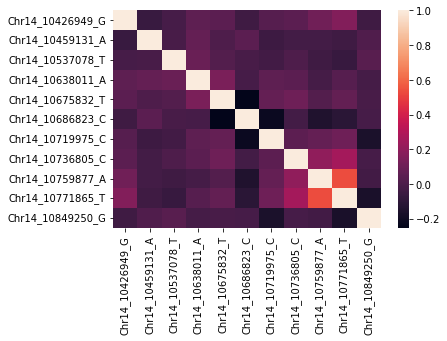

In [94]:
generateHeatMap('Chr14_10686823_C', 5)

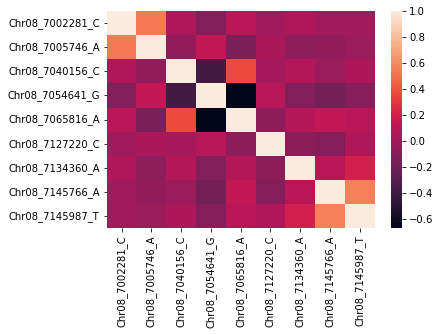

In [95]:
generateHeatMap('Chr08_7065816_A', 4)  # Nice triplet

We can check there's a decent correlation between Chr08_7005746_A and Chr08_7002281_C. Also, Chr08_7145766_A and Chr08_7145987T showed a strong correlation.

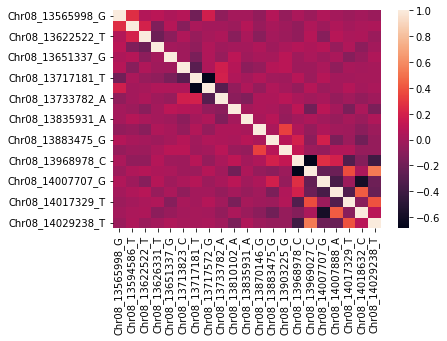

In [96]:
generateHeatMap('Chr08_13835931_A', 10) # Nothing interesting

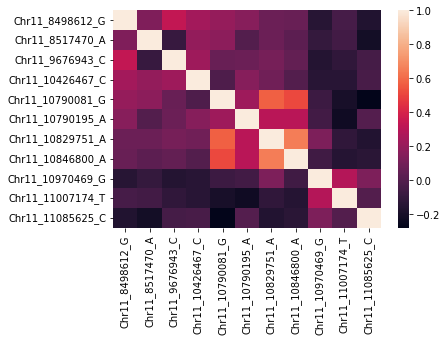

In [105]:
generateHeatMap('Chr11_10790195_A', 5) # highly correlated subgroup 

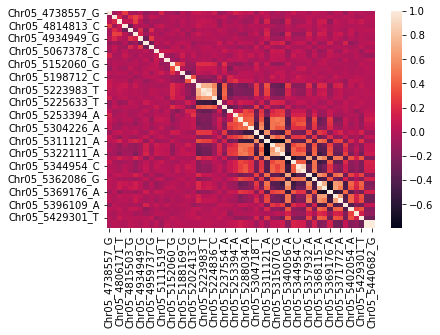

In [97]:
generateHeatMap('Chr05_5268120_G',25) # Interesting group containg plenty of correlated variables

Here, Chr05_5222154_T, Chr05_5223983_T, and Chr05_5224099_C make a subgroup of variants. Additionally, Chr05_5315070_G and Chr05_5322111_A are highly correlated.

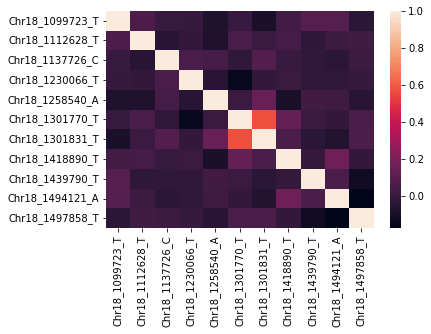

In [98]:
generateHeatMap('Chr18_1301770_T', 5) # Nice pair

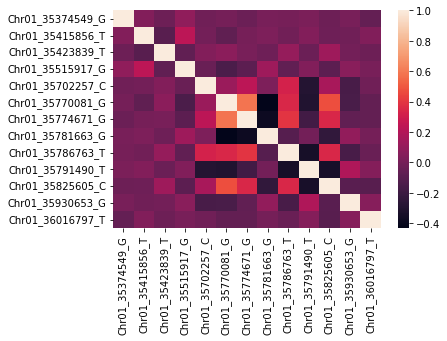

In [99]:
generateHeatMap('Chr01_35774671_G', 6) # Nice subgroup

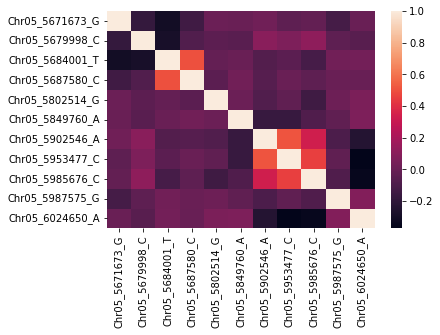

In [100]:
generateHeatMap('Chr05_5849760_A', 5)

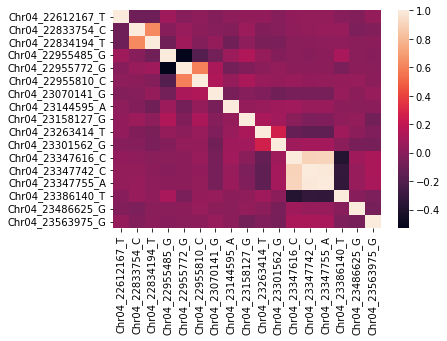

In [101]:
generateHeatMap('Chr04_23158127_G', 8)

It is shown that Chr04_233477616_C, Chr04_23347742_C, Chr04_23347755_A are strongly correlated subvariants.

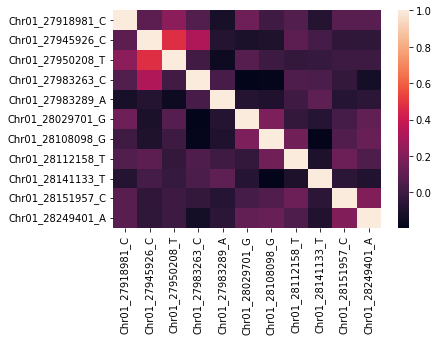

In [102]:
generateHeatMap('Chr01_28029701_G', 5)

In conclusion, we figured out high correlated chromossome subgroup based on cloud density -- 'Chr11_10790195_A'!

---
To be sure, we can check the extra map that minimum temperature has as well!

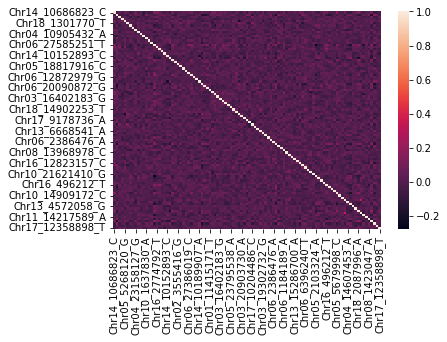

In [109]:
def top(k):
    important1 = map(lambda pair: pair[1][0], variants1[0:k+1])
    seaborn.heatmap(X_cd_knn[important1].corr())
top(100) # Look at top 100 features for cloud density

For the heatmap of cloud density key variants, we have a couple of subvariant groups, centered at ‘Chr05_5223983_T’ and ‘Chr05_5322111_A’, neighboring key variant 'Chr05_5268120_G'’; key variant 'Chr01_35774671_G' has a directly related pair subvariant ‘Chr01_3577081_G’; around our key variant ‘Chr04_23158127_G', there is an extremely highly correlated group of three genes Chr04_23347616_C, Chr04_23347742_C, Chr04_23347755_A.